In [34]:
import numpy as np
import pandas as pd
import warnings
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
cj = pd.read_csv('example_journey.csv')

In [3]:
cj.head()

,Unnamed: 0,path,conv,conv_null,Unnamed: 4
0,1,SEM BRAND > SEM NON BRAND > SHOPPING,1,0,NaN
1,2,SHOPPING,1,0,NaN
2,3,SHOPPING,1,0,NaN
3,4,SHOPPING > OTHERS > RETARGETING > OTHERS > RET...,1,0,NaN
4,5,SEM BRAND,1,0,NaN


All journeys in this dataframe are converting journeys. This is indicated by column conv_null

In [11]:
def strip_repeat_channels(df, path = 'path'):
    """Strip journeys like > SHOPPING > SHOPPING > SHOPPNG > DIRECT into > SHOPPING > DIRECT
    For removale effect calculation same to same channel is not relevant
    Ends > conversion or no_conversion to path based on conv column
    
    INPUT: df = dataframe with paths, path = columnname of paths
    OUTPUT: same dataframe with cleaned journeys and list of channel names
    """
    df = df.copy()
    
    #Get all channel names
    all_chnl = []
    for p in df[path]:
        all_chnl.extend(p.split(' > '))
    
    #Get all unique channels
    all_chnl_unique = list(set(all_chnl))
    
    
    #Add start and end touchpint
    df[path] = [ 'start > ' + p + ' > conversion' if c==1 else 'start > ' + p + ' > no_conversion' for c, p in zip(cj['conv'], cj[path])]
    
    
    #Strip consecutive repeats
    for chnl in set(all_chnl):
        df.path =  [re.sub("(> "+chnl+" )+", "> "+chnl+" ", p) for p in df[path]]
        
    return all_chnl_unique, df
 
def calc_trans_matrix(df, channels, path = 'path'):
    """
    Output: Transition matrix 
    Input: dataframe containing journeys in the format START > CHANNEL1 > CHANNEL2 > ... > conversion|no_conversion
    """
    trans = [[0]*(len(channels)+1) for _ in range(len(channels)+1)]
    for i, i_from in enumerate(channels):
        i = i+1
        trans[i][len(channels)] = sum([p.endswith(i_from + ' > conversion') for p in df[path]])/sum([p.count(i_from) for p in df[path]])      

        for j, j_to in enumerate(channels):
            trans[0][j] = sum([p.startswith('start > ' + j_to) for p in df[path]])/len(df[path])
        
            if sum([p.count(i_from) for p in df[path]]) >0:   
                trans[i][j] = sum([p.count(i_from + ' > ' + j_to) for p in df[path]])/ sum([p.count(i_from) for p in df[path]])

    return trans

In [10]:
def simulate_removal_path(trans_matrix, simulation_n, all_chnl, max_length, remove_chnl = 'NONE'):
    """
    Function simulates n paths returns the amount of converted paths.
    If remove_chnl != NONE functions simulates paths after removal
    trans_matrix = transition matrix
    simulation_n = amount of paths to simulate
    remove_chnl = removed channel    
    """
    all_chnl = all_chnl + ['conversion']
    trans_val = dict(zip(all_chnl, range(1,len(all_chnl)+1)))
    count_conv = 0

    for j in range(0,simulation_n):
        journey = []
        x = random.choices(population = all_chnl, weights= trans_matrix[0], k=1)

        journey.append(x[0])
        for cj_step in range(0, max_length):   
            if x[0] == 'conversion':
                count_conv = count_conv +1
                #print(journey)
                break
            if (x[0] == remove_chnl) | (x[0] == 'no_conversion'):
                #break journey, if next simulated channel is either removed or ends without conversion
                break
            x = random.choices(population = all_chnl, weights = trans_matrix[trans_val[x[0]]], k=1)
            journey.append(x[0])
    return count_conv

In [21]:
def removal_effects(cj, simulation_n, max_length = 'max', path = 'path'):
    """
    Function calculates removal effects for dataframe cj.
    cj = input df with paths
    simulation_n = paths to simulate
    max_length = max length of journey
    path = column name in cj containing paths as string
    """
        
    if max_length == 'max':
        max_length = cj.path.str.count('>').max()+1
        print('Max length of journey in dataset: ', max_length)
        
    all_chnl, cj_clean = strip_repeat_channels(cj, path = path)
    trans_matrix = calc_trans_matrix(cj_clean, all_chnl, path = path)
    
    count_conv = simulate_removal_path(trans_matrix, simulation_n, all_chnl, max_length)
    print(count_conv)
    removal_effects = []
    for remove_chnl in all_chnl:
        count_conv_removal = simulate_removal_path(trans_matrix, simulation_n, all_chnl, max_length, remove_chnl= remove_chnl)
        
        removal = 1 - count_conv_removal/count_conv
        removal_effects.append([remove_chnl, removal])
        print('removal ', remove_chnl, ': ',removal)
    return trans_matrix, removal_effects, all_chnl

In [27]:
trans_matrix, removal, all_chnl = removal_effects(cj, 10000, max_length = 'max', path = 'path')

Max length of journey in dataset:  12
9998
removal  SEM NON BRAND :  0.06811362272454491
removal  DIRECT :  0.2594518903780756
removal  CRM :  0.13602720544108826
removal  PARTNERS :  0.01940388077615518
removal  RETARGETING :  0.03770754150830169
removal  SEO NON BRAND :  0.0859171834366873
removal  SHOPPING :  0.7514502900580116
removal  SEM BRAND :  0.19693938787757548
removal  DISPLAY :  0.01640328065613128
removal  OTHERS :  0.02000400080016007


In [46]:
trans_matrix, removal, all_chnl = removal_effects(cj, 10000, max_length = 100, path = 'path')

10000
removal  SEM NON BRAND :  0.06710000000000005
removal  DIRECT :  0.2552
removal  CRM :  0.12949999999999995
removal  PARTNERS :  0.018000000000000016
removal  RETARGETING :  0.034599999999999964
removal  SEO NON BRAND :  0.0847
removal  SHOPPING :  0.7431
removal  SEM BRAND :  0.20479999999999998
removal  DISPLAY :  0.020399999999999974
removal  OTHERS :  0.022399999999999975


In [28]:
pd.DataFrame(columns = ['Channel', 'removal_effect'], data = removal)

,Channel,removal_effect
0,SEM NON BRAND,0.068114
1,DIRECT,0.259452
2,CRM,0.136027
3,PARTNERS,0.019404
4,RETARGETING,0.037708
5,SEO NON BRAND,0.085917
6,SHOPPING,0.751450
7,SEM BRAND,0.196939
8,DISPLAY,0.016403
9,OTHERS,0.020004


In [29]:
trans_matrix

[[0.03389830508474576,
  0.11864406779661017,
  0.0,
  0.01694915254237288,
  0.0,
  0.0847457627118644,
  0.5932203389830508,
  0.13559322033898305,
  0.01694915254237288,
  0.0,
  0],
 [0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.25],
 [0.0625, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.3125, 0.125, 0.0, 0.0, 0.4375],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.75],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.3333333333333333,
  0.6666666666666666],
 [0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0],
 [0.0,
  0.043478260869565216,
  0.06521739130434782,
  0.0,
  0.021739130434782608,
  0.0,
  0.0,
  0.021739130434782608,
  0.0,
  0.021739130434782608,
  0.8260869565217391],
 [0.08333333333333333,
  0.3333333333333333,
  0.16666666666666666,
  0.0,
  0.0,
  0.0,
  0.08333333333333333,
  0.0,
  0.0,
  0.0,
  0.3333333333333333],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 

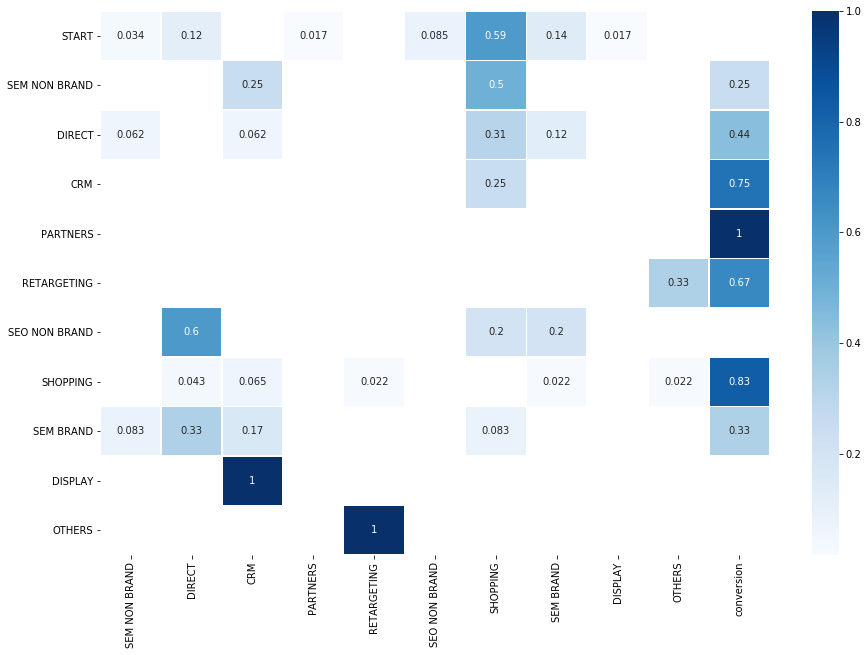

In [45]:
trans_df = pd.DataFrame(trans_matrix)
trans_df.columns = all_chnl + ['conversion']
trans_df.index = ['START'] + all_chnl
f, axs = plt.subplots(figsize=(15,10))
axs = sns.heatmap(trans_df, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), linewidths=.5,mask=(trans_df==0))#"YlGnBu")


In [40]:
trans_df.sum(axis=1)

START            1.0
SEM NON BRAND    1.0
DIRECT           1.0
CRM              1.0
PARTNERS         1.0
RETARGETING      1.0
SEO NON BRAND    1.0
SHOPPING         1.0
SEM BRAND        1.0
DISPLAY          1.0
OTHERS           1.0
dtype: float64